In [7]:
import os, glob, shutil, datetime
import numpy as np 
import math, matplotlib, time
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText
from scipy.interpolate import griddata
import pandas as pd
import ternary
import matplotlib.path as mpath
star = mpath.Path.unit_regular_star(6)
matplotlib.rc('font',size=16)
# %matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('.')

import pdfchem
import mercury as mr

def screen_time():
    return datetime.datetime.now().strftime("\033[0;32m%H:%M:%S %Y-%m-%d > \33[0m")

In [8]:
app = mr.App(title="PDFchem 3.0 beta 3 - Matplotlib", description="interactive PDF analysis")
max_workers = 1
mr_output_dir = mr.OutputDir()

mercury.App

In [9]:
# Hello in PDFchem! 👋

In [38]:
plot_input_PDF=False

PDF_input_flag = mr.Checkbox(value=False, label="Switch on to use your PDF files", url_key="flag")
if not PDF_input_flag.value:
    metallicity = mr.Select(value="1", choices=["0.1", "0.5", "1", "2"], label='Metallicity:')
    _mean = mr.Numeric(value=4, min=0.6, max=20, step=0.2, label=r'Mean: Av_bar')
    _width = mr.Numeric(value=0.32, min=0.12, max=1.02, step=0.1, label='Width: Sigma')
    output_file = 'output.dat'
    run_model_button = mr.Button(label="Run model PDF", style="primary")

if PDF_input_flag.value:
    plot_input_PDF=True
    multi_PDF_flag = mr.Checkbox(value=False, label="Switch on to run multiple Av-PDF files", url_key="multi PDF flag")
    if multi_PDF_flag.value:
        #PDF_path = my_PDF.filepath
        PDF_path = mr.Text(value="./avpdf_input/", label="Enter a folder containing your Av-PDF files", rows=1)
        avpdf_files = sorted(glob.glob(os.path.join(PDF_path.value,'*')))
        mr.Md(f"## WARNING: will run PDFchem with all files in `{PDF_path.value}`!")
        mr.Md(f"## This could be very slow if you have many files!")
        metallicity = mr.Select(value="1", choices=["0.1", "0.5", "1", "2"], label='Metallicity:')
        run_multi_button = mr.Button(label="Run multiple PDF", style="primary")
        my_PDf = avpdf_files[0]
    if not multi_PDF_flag.value :
        my_PDF = mr.File(label="Please upload an Av_PDF file", max_file_size="100MB")
        metallicity = mr.Select(value="1", choices=["0.1", "0.5", "1", "2"], label='Metallicity:')
        run_single_button = mr.Button(label="Run a single PDF", style="primary")
        

mercury.Checkbox

mercury.Select

mercury.Numeric

mercury.Numeric

mercury.Button

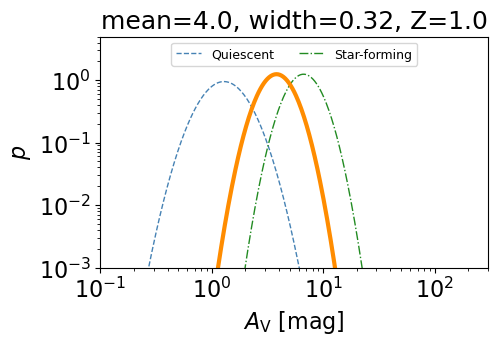

In [43]:
av_diff, pdf_diff, avtot_diff = pdfchem.makepdf(1.4, 0.42)
av_sf, pdf_sf, avtot_sf = pdfchem.makepdf(7, 0.32)
fig, ax = plt.subplots(figsize=(5,3))
ax.loglog(av_diff, pdf_diff, '--', lw=1, color='steelblue', label='Quiescent')
ax.loglog(av_sf, pdf_sf, '-.', lw=1, color='forestgreen', label = 'Star-forming')
ax.legend(fontsize=9, ncols=2, loc= 'upper center')
ax.set_xlim(0.1,300)
ax.set_ylim(1e-3, 5)
ax.set_xlabel(r'$A_{\rm V}$ [mag]')
ax.set_ylabel(r'$p$')
if not PDF_input_flag.value:
    av_bar, s, metallicity = _mean.value, _width.value, float(metallicity.value)
    av_m, pdf_m, avtot = pdfchem.makepdf(av_bar, s)
    ax.loglog(av_m, pdf_m, '-', lw=3, color='darkorange')
    ax.set_title(f'mean={av_bar:3.1f}, width={s:4.2f}, Z={metallicity:3.1f}',fontsize=18)
    #ax.grid()
elif my_PDF.filename:
    try:
        d = np.genfromtxt(my_PDF.filepath)  # user specified PDF
        av = d[:,0]; pdf = d[:,1]
        ax.loglog(av,pdf,'-',lw=3)
    except:
        if my_PDF.filename[-4:] == 'fits':
            av, pdf = pdfchem.NH_fits_to_pdf(my_PDF.filepath)
            ax.loglog(av,pdf,'-',lw=3)

In [28]:
plot_species = mr.Select(value="Tco10", choices=[
"Tgas", "C+", "C",  "CO", "OI",  "HI",  "H2", 'HI_H2_ratio', "OHp",  "H2Op",  "OH", "CH",  "HCO+", "Tcii",  "Tci10",  "Tci21", "Tco10", "Tco21",  "Tco32", "Tco43",  "Tco54",  "Tco65", "Tco76",  "Tco87",  "Tco98", "Tco109" 
], label="Select a specie to plot the result.")

mercury.Select

In [29]:
ref_value_flag = mr.Checkbox(value=False, label="Switch on to enter a reference value", url_key="flag")
if ref_value_flag.value:
    ref_value = mr.Numeric(value=1, min=0, max=1e12, label="Enter a reference value to show on the result figure")

mercury.Checkbox

In [30]:
make_collective_figs_button = mr.Button(label="Show collective figures", style="primary")
make_carbon_figs_button = mr.Button(label="Show carbon cycle figures", style="primary")

mercury.Button

mercury.Button

In [31]:
#colour map setup
cmap = plt.cm.get_cmap("viridis")

my_cmap = cmap(np.arange(cmap.N))
alphas = np.linspace(0.6,0.6,cmap.N)
BG = np.asarray([1.,1.,1.])
for i in range(cmap.N):
    my_cmap[i,:-1] = my_cmap[i,:-1] * alphas[i] + BG*(1.-alphas[i])
my_cmap = ListedColormap(my_cmap)
cmap=my_cmap

In [45]:
if not PDF_input_flag.value:
    writeout = np.column_stack((_mean.value, _width.value, metallicity))
    np.savetxt('pdfchem.params',writeout,delimiter=' ',fmt='%1.4e')

def process_file(avpdf_file):
    file_index =  avpdf_file.split('/')[-1].split('.')[0][-6:]
    pdfchem_output_file = os.path.join(f'./pdfchem_output', f'output{file_index}.dat')
    pdfchem.main(avpdf_file, pdfchem_output_file)
    shutil.copy(pdfchem_output_file, mr_output_dir.path)
    return

startTime = time.time()

if run_model_button.clicked:
    pdfchem.main()
    shutil.copy('output.dat', mr_output_dir.path) 
    executionTime = round(time.time() - startTime, 1)
    print(f'Execution time: {executionTime} seconds.')
    print(f"Output data file is available for download.")
else:
    try: 
        if run_single_button.clicked:    
            pdfchem.main(my_PDF.filepath)
            shutil.copy('output.dat', mr_output_dir.path) 
            executionTime = round(time.time() - startTime, 1)
            print(f'Execution time: {executionTime} seconds.')
            print(f"Output data file is available for download.")
    except: pass
    try: 
        if run_multi_button.clicked:  
            print(f'{screen_time()} \033[0;31mPDFchem \33[0m started.')
            if not os.path.exists('./pdfchem_output'): os.mkdir('./pdfchem_output')
            for avpdf_file in avpdf_files:
                process_file(avpdf_file)
                print(f'{screen_time()} \033[0;31m{avpdf_file}\33[0m completed')
            # output_file = sorted(glob.glob(os.path.join('pdfchem_output','*.dat')))[0]
            executionTime = round(time.time() - startTime, 1)
            print(f'Execution time: {executionTime} seconds.')
            print(f'Output data files are saved to folder: "pdfchem_output".')
    except: pass

# 45    seconds with i7-1165G7 @ 2.80GHz with Multiprocessing ON
# 15.7  seconds with AMD Ryzen 9 5900HX
# 8.1   seconds with M1 pro
# 3.3   seconds with i9-12900K
# 2.5   seconds with Xeon(R) Platinum 8358

In [33]:
# read the output from the algorithm
title = r'PDFchem result'

In [34]:
# mr.Md(f"""
# ## Sequence of species
# |||||||||||
# |--------|---------|----------|---------|---------|-------|--------|---------|---------|-------|
# | 1: H3+ | 2: He+  | 3: Mg    | 4: H2+  | 5: CH5+ | 6: O2 |7: CH4+ |8: O+    |9: OH+   |10: Mg+|
# |11: C+  |12: CH4  |13: H2O+  |14: H3O+ |15: CO+  |21: CH |22: CH3 |23: HCO+ |24: CH2+ |25: C  | 
# |26: He  |27: CH+  |28: CO    |29: OH   |30: O    |31: H2 |32: H   |33: e-   |         |       |
# ## Results will be placed in `./pdfchem_output`
# """)

In [35]:
#CHEMISTRY RESULTS
try:
    d = np.genfromtxt(output_file)

    #UV radiation (Draine); cosmic-ray ionization rate (s-1); metallicity (Zsolar)
    UV = d[:,0]; CR = d[:,1]; Z = d[:,2]
    #Gas temperature
    Tgas = d[:,3]
    #Abundances of CII; CI; CO; OI; HI; H2; OH+; H2O+; OH; CH; HCO+
    Cp = d[:,14]; C = d[:,28]; CO = d[:,31]
    OI = d[:,33]; HI = d[:,35]; H2 = d[:,34]
    OHp = d[:,12]; H2Op = d[:,16]; OH = d[:,32]
    CH = d[:,24]; HCOp = d[:,26]
    HI_H2_ratio = HI/H2/2
    #the above are some of the available species
    #follow the sequence of species by adding 3 to plot any other available

    #Brightness temperatures of [CII]158; [CI](1-0); [CI](2-1)
    Tcii = d[:,37]; Tci10 = d[:,38]; Tci21 = d[:,39]
    #CO(1-0); CO(2-1); ... CO(10-9)
    Tco10 = d[:,40]; Tco21 = d[:,41]; Tco32 = d[:,42] 
    Tco43 = d[:,43]; Tco54 = d[:,44]; Tco65 = d[:,45]
    Tco76 = d[:,46]; Tco87 = d[:,47]; Tco98 = d[:,48]
    Tco109 = d[:,49]
except:
    pass   

#AV-PDF 
try:
    d = np.genfromtxt(avpdf_file)  # user specified PDF
    av = d[:,0]; pdf = d[:,1]
    av_bar = 'user AV-PDF'
    s = '*'
    #av = 10**d[:,0]
except:
    d = np.genfromtxt('avpdf.dat')       # program generated PDF

myVars = globals()
#for plotting the grid
xi = np.linspace(min(np.log10(CR)), max(np.log10(CR)), 50)
yi = np.linspace(min(np.log10(UV)), max(np.log10(UV)), 50)
points = np.array([np.log10(CR),np.log10(UV)]).T

In [36]:
def grid_data(values):
    # try:
    #     zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(values),xi,yi,interp='linear') 
    # except:
    zi = griddata(points,np.log10(values),(xi,yi),method='linear') 
    return(zi)

Text(0.5, 0.95, 'log Tco10')

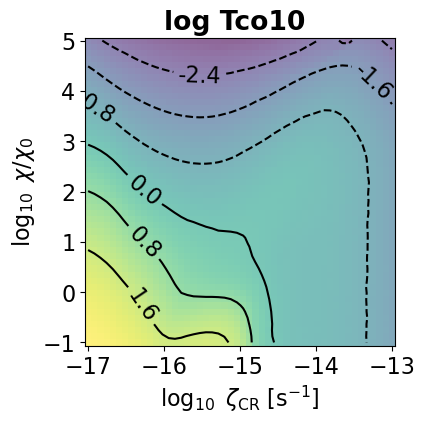

In [37]:
#Individual plot

#Enter quantity to plot (ratios are generally preferred, especially for brightness temperatures)
 
species = plot_species.value
if species == 'C+':      qty = Cp
else:   
    qty = myVars[species]
# e.g. 'CO' for CO abundance, 'Tco21/Tco10' for CO(2-1)/CO(1-0)
#title = r'T(CO 1-0)'
title = species
if title == 'HI_H2_ratio':  title = f'HI/H$_2$'

ax = plt.figure(figsize=(4,4))
N=6 #No. contours

try:
    #HI-H2 transition
    zi_tr = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HI/2./H2),xi,yi,interp='linear') 
    #make grid of the quantity qty
    zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(qty),xi,yi,interp='linear')
except:        # in newer versions of matplotlib there isn't mlab.griddata(), so use scipy instead:
    xi,yi = np.mgrid[min(np.log10(CR)):max(np.log10(CR)):50j, min(np.log10(UV)):max(np.log10(UV)):50j]
    zi_tr = griddata(points,np.log10(HI/2./H2),(xi,yi),method='linear') 
    zi_tco10 = griddata(points,np.log10(Tco10),(xi,yi),method='linear') 
    zi = griddata(points,np.log10(qty),(xi,yi),method='linear')

#title = title
if '/' in title:    dir_output=title.replace('/','_to_')
else:               dir_output = title
plt.pcolormesh(xi,yi,zi,cmap=cmap)
# plt.contour(xi,yi,zi_tr,[0],colors='crimson',linewidths=3.0,linestyles='dashed') #plot HI-H2 transition (red line)
#plt.contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0) #plot HI-H2 transition (red line)
try:
    plt.contour(xi,yi,zi,[np.log10(ref_value.value)],colors='m',linewidths=3.0, alpha=1) #plot HI-H2 transition (red line)
except:
    pass
CS = plt.contour(xi,yi,zi,N,colors='k')
plt.clabel(CS,fmt='%1.1f')

plt.xticks([-17,-16,-15,-14,-13])
plt.yticks([-1,0,1,2,3,4,5])
plt.xlabel(r'$\log_{10}\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
plt.ylabel(r'$\log_{10}\,\,\chi/\chi_0$')
plt.suptitle(f'log {title}', weight='bold',y=0.95)
# plt.text(-15.5, 5.1, title, weight='bold', fontsize = 20)

#individual_fig_path = os.path.join('Fig_{}.format(dir_output)', '{}_{}.png'.format(dir_output, pdf_i))
#plt.savefig(individual_fig_path, bbox_inches='tight')

In [16]:
if make_collective_figs_button.clicked:
#Collective plot similar to paper

    fig, axs = plt.subplots(4, 5, figsize=(20,19))

    xt = -16.85; yt = -0.65; N=6
    try:
        zi_tr = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HI/2./H2),xi,yi,interp='linear') 
        zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(qty),xi,yi,interp='linear')
    except:        # in newer versions of matplotlib there isn't mlab.griddata(), so use scipy instead:
        xi,yi = np.mgrid[min(np.log10(CR)):max(np.log10(CR)):50j, min(np.log10(UV)):max(np.log10(UV)):50j]
        zi_tr = griddata(points,np.log10(HI/2./H2),(xi,yi),method='linear') 

    #zi_tr = grid_data(HI/2./H2)
    axs[0,0].pcolormesh(xi,yi,zi_tr,cmap=cmap)
    CS = axs[0,0].contour(xi,yi,zi_tr,N,colors='k')
    axs[0,0].clabel(CS,fmt='%1.1f')
    CS = axs[0,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    text_box = AnchoredText("a", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[0,0].add_artist(text_box)
    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([-1, 0, 1, 2, 3, 4, 5])
    axs[0,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
    axs[0,0].set_title('HI-to-H2')

    #zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CII),xi,yi,interp='linear')
    zi = grid_data(CII)
    axs[0,1].pcolormesh(xi,yi,zi,cmap=cmap)
    CS = axs[0,1].contour(xi,yi,zi,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    CS = axs[0,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    text_box = AnchoredText("b", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[0,1].add_artist(text_box)
    axs[0,1].set_xticks([])
    axs[0,1].set_yticks([])
    axs[0,1].set_title('CII abundance')

    #zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CI),xi,yi,interp='linear')
    zi = grid_data(CI)
    axs[0,2].pcolormesh(xi,yi,zi,cmap=cmap)
    CS = axs[0,2].contour(xi,yi,zi,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    CS = axs[0,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    text_box = AnchoredText("c", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[0,2].add_artist(text_box)
    axs[0,2].set_xticks([])
    axs[0,2].set_yticks([])
    axs[0,2].set_title('CI abundance')

    #zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CO),xi,yi,interp='linear')
    zi = grid_data(CO)
    axs[0,3].pcolormesh(xi,yi,zi,cmap=cmap)
    CS = axs[0,3].contour(xi,yi,zi,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    CS = axs[0,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    text_box = AnchoredText("d", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[0,3].add_artist(text_box)
    axs[0,3].set_xticks([])
    axs[0,3].set_yticks([])
    axs[0,3].set_title('CO abundance')

    #zi = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tgas),xi,yi,interp='linear')
    zi = grid_data(Tgas)
    axs[0,4].pcolormesh(xi,yi,zi,cmap=cmap)
    CS = axs[0,4].contour(xi,yi,zi,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    CS = axs[0,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    text_box = AnchoredText("e", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[0,4].add_artist(text_box)
    axs[0,4].set_xticks([])
    axs[0,4].set_yticks([])
    axs[0,4].set_title(r'log T$_{\rm gas}$ [K]')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(OH),xi,yi,interp='linear')
    zi_R = grid_data(OH)
    axs[1,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[1,0].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[1,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[1,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("f", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[1,0].add_artist(text_box)
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([-1, 0, 1, 2, 3, 4, 5])
    axs[1,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
    axs[1,0].set_title('OH abundance')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(OHp),xi,yi,interp='linear')
    zi = grid_data(OHp)
    axs[1,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[1,1].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[1,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[1,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("g", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[1,1].add_artist(text_box)
    axs[1,1].set_xticks([])
    axs[1,1].set_yticks([])
    axs[1,1].set_title(r'OH$^+$ abundance')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(H2Op),xi,yi,interp='linear')
    zi_R = grid_data(H2Op)
    axs[1,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[1,2].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[1,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[1,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("h", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[1,2].add_artist(text_box)
    axs[1,2].set_xticks([])
    axs[1,2].set_yticks([])
    axs[1,2].set_title(r'H$_2$O$^+$ abundance')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(CH),xi,yi,interp='linear')
    zi_R = grid_data(CH)
    axs[1,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[1,3].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[1,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[1,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("i", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[1,3].add_artist(text_box)
    axs[1,3].set_xticks([])
    axs[1,3].set_yticks([])
    axs[1,3].set_title('CH abundance')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(HCOp),xi,yi,interp='linear')
    zi_R = grid_data(HCOp)
    axs[1,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[1,4].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[1,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[1,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("j", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[1,4].add_artist(text_box)
    axs[1,4].set_xticks([])
    axs[1,4].set_yticks([])
    axs[1,4].set_title(r'HCO$^+$ abundance')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci21/Tci10),xi,yi,interp='linear')
    zi_R = grid_data(Tci21/Tci10)
    axs[2,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[2,0].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[2,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[2,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("k", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[2,0].add_artist(text_box)
    axs[2,0].set_xticks([])
    axs[2,0].set_yticks([-1, 0, 1, 2, 3, 4, 5])
    axs[2,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
    axs[2,0].set_title('[CI](2-1) / [CI](1-0)')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco21/Tco10),xi,yi,interp='linear')
    zi_R = grid_data(Tco21/Tco10)
    axs[2,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[2,1].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[2,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[2,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("l", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[2,1].add_artist(text_box)
    axs[2,1].set_xticks([])
    axs[2,1].set_yticks([])
    axs[2,1].set_title('CO(2-1) / CO(1-0)')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco32/Tco10),xi,yi,interp='linear')
    zi_R = grid_data(Tco32/Tco10)
    axs[2,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[2,2].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[2,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[2,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("m", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[2,2].add_artist(text_box)
    axs[2,2].set_xticks([])
    axs[2,2].set_yticks([])
    axs[2,2].set_title('CO(3-2) / CO(1-0)')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco43/Tco10),xi,yi,interp='linear')
    zi_R = grid_data(Tco43/Tco10)
    axs[2,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[2,3].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[2,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[2,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("n", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[2,3].add_artist(text_box)
    axs[2,3].set_xticks([])
    axs[2,3].set_yticks([])
    axs[2,3].set_title('CO(4-3) / CO(1-0)')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tco54/Tco10),xi,yi,interp='linear')
    zi_R = grid_data(Tco54/Tco10)
    axs[2,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[2,4].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[2,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[2,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("o", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[2,4].add_artist(text_box)
    axs[2,4].set_xticks([])
    axs[2,4].set_yticks([])
    axs[2,4].set_title(r'CO(5-4) / CO(1-0)')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci21/Tco76),xi,yi,interp='linear')
    zi_R = grid_data(Tci21/Tco76)
    axs[3,0].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[3,0].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[3,0].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[3,0].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("p", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[3,0].add_artist(text_box)
    axs[3,0].set_xticks([-17, -16, -15, -14])
    axs[3,0].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
    axs[3,0].set_yticks([-1, 0, 1, 2, 3, 4, 5])
    axs[3,0].set_title(r'[CI](2-1) / CO(7-6)')
    axs[3,0].set_ylabel(r'$\log\,\,\chi/\chi_0$')
    axs[3,0].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci10/Tco43),xi,yi,interp='linear')
    zi_R = grid_data(Tci10/Tco43)
    axs[3,1].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[3,1].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[3,1].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[3,1].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("q", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[3,1].add_artist(text_box)
    axs[3,1].set_xticks([-17, -16, -15, -14])
    axs[3,1].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
    axs[3,1].set_yticks([])
    axs[3,1].set_title(r'[CI](1-0) / CO(4-3)')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tci10/Tco10),xi,yi,interp='linear')
    zi_R = grid_data(Tci10/Tco10)
    axs[3,2].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[3,2].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[3,2].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[3,2].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("r", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[3,2].add_artist(text_box)
    axs[3,2].set_xticks([-17, -16, -15, -14])
    axs[3,2].set_yticks([])
    axs[3,2].set_title(r'[CI](1-0) / CO(1-0)')
    axs[3,2].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tcii/Tci10),xi,yi,interp='linear')
    zi_R = grid_data(Tcii/Tci10)
    axs[3,3].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[3,3].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[3,3].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[3,3].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("s", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[3,3].add_artist(text_box)
    axs[3,3].set_xticks([-17, -16, -15, -14])
    axs[3,3].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
    axs[3,3].set_yticks([])
    axs[3,3].set_title(r'[CII] / [CI](1-0)')

    #zi_R = ml.griddata(np.log10(CR),np.log10(UV),np.log10(Tcii/Tco10),xi,yi,interp='linear')
    zi_R = grid_data(Tcii/Tco10)
    axs[3,4].pcolormesh(xi,yi,zi_R,cmap=cmap)
    CS = axs[3,4].contour(xi,yi,zi_R,N,colors='k')
    plt.clabel(CS,fmt='%1.1f')
    axs[3,4].contour(xi,yi,zi_tr,[0],colors='r',linewidths=3.0)
    axs[3,4].contour(xi,yi,zi_R,[0],colors='w',linewidths=3.0)
    text_box = AnchoredText("t", prop=dict(fontweight="bold",fontsize=20), frameon=True, loc=4, pad=0.3)
    plt.setp(text_box.patch, boxstyle="round", facecolor='white', alpha=0.9)
    axs[3,4].add_artist(text_box)
    axs[3,4].set_xticks([-17, -16, -15, -14, -13])
    axs[3,4].set_xlabel(r'$\log\,\,\zeta_{\rm CR}$ [s$^{-1}$]')
    axs[3,4].set_yticks([])
    axs[3,4].set_title(r'[CII] / CO(1-0)')


    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    #plt.suptitle(title, y=0.93, weight='bold')

    #collective_fig_path = os.path.join('Fig_Collective', 'Collective_{}.png'.format(pdf_i))
    #plt.savefig(collective_fig_path, bbox_inches='tight')

In [17]:
if  make_carbon_figs_button.clicked:
    d = pd.read_table(output_file, header=None, sep='\s+')
    d.rename(columns= { 0: 'UV', 1: 'CR', 2: 'Z', 3: 'Tgas', 14: 'CII', 28: 'CI', 31: 'CO', 33: 'OI', 35: 'HI', 34: 'H2', 12: 'OHp', 16: 'H2Op', 32: 'OH', 24: 'CH', 26: 'HCOp',
            },
            inplace=True)

    # make contours for UV and CR
    for sub_cr in pd.unique(d['CR']):
        cr_g = d[d['CR'] == sub_cr]
        CII = cr_g['CII']; CI = cr_g['CI']; CO = cr_g['CO']
        tot_carbon = CII+CI+CO
        sub_c2,sub_c1,sub_co = CII/tot_carbon, CI/tot_carbon, CO/tot_carbon
        cr_points = []
        for i in range(len(sub_c1)):
            cr_points.append((sub_c2.iloc[i], sub_c1.iloc[i], sub_co.iloc[i]))
    for sub_uv in pd.unique(d['UV']):
        uv_g = d[d['UV'] == sub_uv]
        CII = uv_g['CII']; CI = uv_g['CI']; CO = uv_g['CO']
        tot_carbon = CII+CI+CO
        sub_c2,sub_c1,sub_co = CII/tot_carbon, CI/tot_carbon, CO/tot_carbon
        uv_points = []
        for i in range(len(sub_c1)):
            uv_points.append((sub_c2.iloc[i], sub_c1.iloc[i], sub_co.iloc[i]))


    def plot_carbon(uv, cr, z):
        # Create boolean masks for each condition
        uv_diff = np.abs(d['UV'] - 10**uv)
        cr_diff = np.abs(d['CR'] - 10**cr)
        
        # Use the combined_mask to find the row(s) that satisfy all conditions
        matched_d = d[(np.abs(d['UV'] - 10**uv) == uv_diff.min()) & (np.abs(d['CR'] - 10**cr) == cr_diff.min())]
        CII = matched_d['CII']; CI = matched_d['CI']; CO = matched_d['CO']
        tot_carbon = CII+CI+CO
        c2 = CII/tot_carbon
        c1 = CI/tot_carbon
        co = CO/tot_carbon
        points = (c2.iloc[0], c1.iloc[0], co.iloc[0])
        color = (c2.iloc[0], c1.iloc[0], co.iloc[0], 0.9)
        scale = 1.0
        
        figure, tax = ternary.figure(scale=scale)
        figure.set_size_inches(6, 5.6)
        for sub_cr in pd.unique(d['CR'])[::2]:
            cr_g = d[d['CR'] == sub_cr]
            CII = cr_g['CII']; CI = cr_g['CI']; CO = cr_g['CO']
            tot_carbon = CII+CI+CO
            sub_c2,sub_c1,sub_co = CII/tot_carbon, CI/tot_carbon, CO/tot_carbon
            cr_points = []
            for i in range(len(sub_c1)):
                cr_points.append((sub_c2.iloc[i], sub_c1.iloc[i], sub_co.iloc[i]))
            tax.plot(cr_points, linewidth=2.0, c='xkcd:turquoise', alpha=0.3, label="Curve")
        for sub_uv in pd.unique(d['UV'])[::2]:
            uv_g = d[d['UV'] == sub_uv]
            CII = uv_g['CII']; CI = uv_g['CI']; CO = uv_g['CO']
            tot_carbon = CII+CI+CO
            sub_c2,sub_c1,sub_co = CII/tot_carbon, CI/tot_carbon, CO/tot_carbon
            uv_points = []
            for i in range(len(sub_c1)):
                uv_points.append((sub_c2.iloc[i], sub_c1.iloc[i], sub_co.iloc[i]))
            tax.plot(uv_points, linewidth=2.0, c='xkcd:indigo', alpha=0.4, label="Curve")


        # Draw Boundary and Gridlines
        tax.boundary(linewidth=2.0)
        tax.gridlines(color="silver", multiple=0.1)
        tax.ticks(clockwise=True, axis='lbr', ticks=['0%', '20%', '40%', '60%', '80%', '100%'], fontsize =16, multiple=1, linewidth=2, offset=0.045)
        tax.get_axes().axis('off')
        tax.clear_matplotlib_ticks()

        # Set Axis labels and Title
        fontsize = 20
        offset = 0.14
        tax.right_corner_label("C$^+$", fontsize=fontsize, offset=0.1, c='crimson')
        tax.top_corner_label("C", fontsize=fontsize, offset=0.25, c='forestgreen')
        tax.left_corner_label("CO", fontsize=fontsize, offset=0.05, c='steelblue')
        c2str, c1str, costr = f"{c2.iloc[0]:.0%}", f"{c1.iloc[0]:.0%}", f"{co.iloc[0]:.0%}"
        tax.set_title(f"C$^+$:{c2str}, C:{c1str}, CO:{costr}\n\n", fontsize=fontsize,y=-0.05)
        try:    tax.scatter([points], c=color, s=200, marker=star, edgecolor='none', zorder=5)
        except: pass
        # tax.set_title(f"C$^+$:{c2str}, CI:{c1str}, CO:{costr}\n\n", fontsize=fontsize,y=-0.03)
        tax.show()
        # global filename
        # figure.savefig(f"figures/ternary{filename}.pdf")

    # plot_carbon(4.4, -15.9, 1)
    # plot_carbon(-0.6, -15.7, 1)
    # plot_carbon(-0.4, -15.5, 1)
    plot_carbon(0, -16, 1)


In [3]:
10**1.7785

60.048200890754615